In [31]:
import pandas as pd
from datetime import datetime
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS
import calendar

# Big G notebook Part 3: Rolling the time series
This notebook will attempt to add some features to the dataset and establish encoding to help analyze time_series data

In [32]:
# Here's the pkl - 1,057,461 entries.
on_faults = pd.read_pickle('../data/on_faults.pkl')
on_faults.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057461 entries, 0 to 1057460
Data columns (total 49 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   RecordID                   1057461 non-null  int64         
 1   ESS_Id                     1057461 non-null  int64         
 2   EventTimeStamp             1057461 non-null  datetime64[ns]
 3   eventDescription           1006873 non-null  object        
 4   ecuSoftwareVersion         793094 non-null   object        
 5   ecuSerialNumber            751418 non-null   object        
 6   ecuModel                   1001485 non-null  object        
 7   ecuMake                    1001485 non-null  object        
 8   ecuSource                  1057461 non-null  int64         
 9   spn                        1057461 non-null  int64         
 10  fmi                        1057461 non-null  int64         
 11  active                     1057461 no

Find the closest service center and its distance from the fault code.  Find the season of the year where the fault occured.

In [33]:
# Creating the min_distance_to_service_center feature
on_faults['dist_to_nearest_sc'] = on_faults[['dist_A', 'dist_B', 'dist_C']].min(axis=1)

# Creating the nearest_service_center feature
on_faults['nearest_sc'] = on_faults[['dist_A', 'dist_B', 'dist_C']].idxmin(axis=1)

# Dropping the 'dist_A', 'dist_B', and 'dist_C' columns
on_faults.drop(['dist_A', 'dist_B', 'dist_C'], axis=1, inplace=True)

# Removing the 'dist_' prefix from each value in the 'nearest_sc' column
on_faults['nearest_sc'] = on_faults['nearest_sc'].str.replace('dist_', '')

# Finding the season were the fault occured.
def get_season(month):
    if month in {3, 4, 5}:
        return 'Spring'
    elif month in {6, 7, 8}:
        return 'Summer'
    elif month in {9, 10, 11}:
        return 'Fall'
    else:
        return 'Winter'

# Extracting the month from EventTimeStamp
on_faults['month'] = on_faults['EventTimeStamp'].dt.month

# Creating the season feature based on the month
on_faults['season'] = on_faults['month'].apply(get_season)

# Dropping the month column, as it's not needed anymore
on_faults.drop('month', axis=1, inplace=True)

Finding the season in which the fault occurred

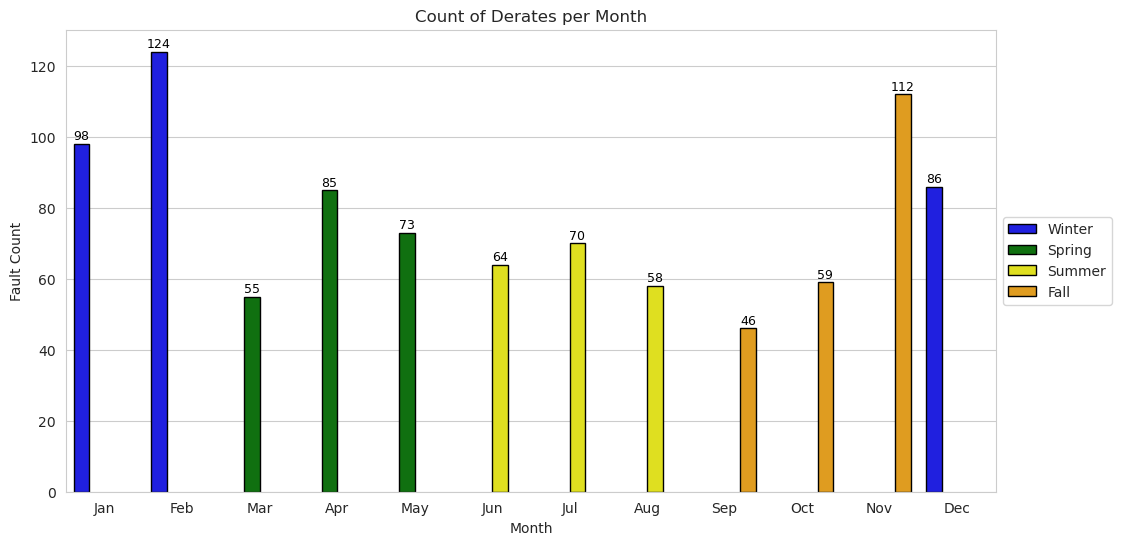

In [34]:
# Filter the on_faults DataFrame for rows with spn == 5246
spn_5246_faults = on_faults[on_faults['spn'] == 5246].copy()

# Extract the month from EventTimeStamp
spn_5246_faults.loc[:, 'month'] = spn_5246_faults['EventTimeStamp'].dt.month

# Count the number of faults per month and season
fault_counts = spn_5246_faults.groupby(['month', 'season']).size().reset_index(name='count')

# Convert month numbers to month names
fault_counts['month'] = fault_counts['month'].apply(lambda x: calendar.month_abbr[x])

# Set the figure size
plt.figure(figsize=(12, 6))

# Create a bar plot with counts per month, color-coded by the season
barplot = sns.barplot(x='month', y='count', hue='season', data=fault_counts, palette=season_palette, edgecolor='black')

# Set plot title and labels
plt.title('Count of Derates per Month')
plt.xlabel('Month')
plt.ylabel('Fault Count')

# Add counts above the bars
for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.0f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='baseline',
                     fontsize=9, color='black',
                     xytext=(0, 3),
                     textcoords='offset points')

# Move the legend outside the graph
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

Finding the seasonal derate count grouped by closest service center

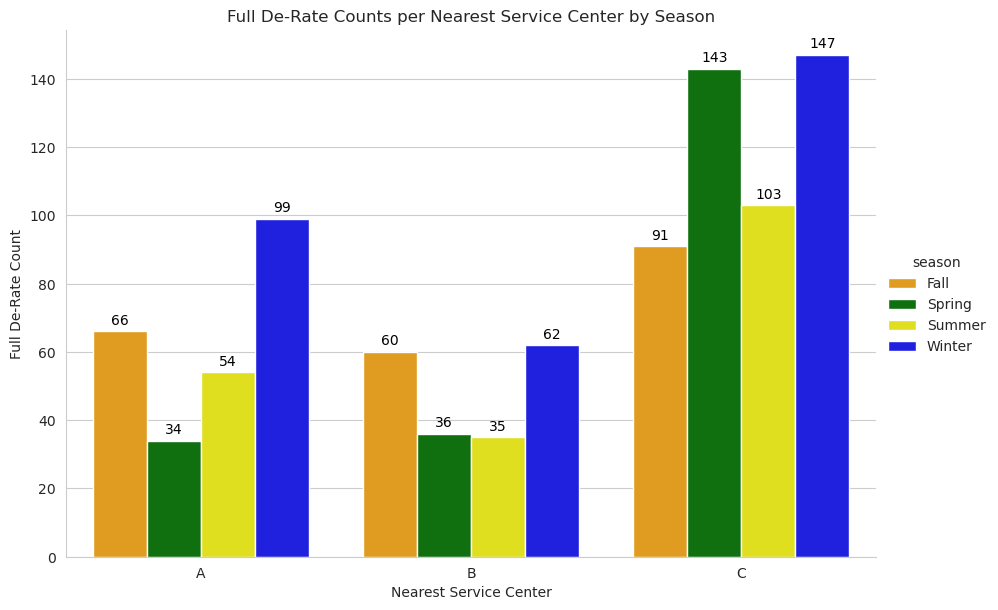

In [41]:
# Filter the on_faults for full derates
spn_5246_faults = on_faults[on_faults['spn'] == 5246]

# Count the number of faults per nearest service center and season
fault_counts = spn_5246_faults.groupby(['nearest_sc', 'season']).size().reset_index(name='count')

# color palette for the seasons
season_palette = {'Spring': 'green', 'Summer': 'yellow', 'Fall': 'orange', 'Winter': 'blue'}

# categorical plot of fault counts
catplot = sns.catplot(x='nearest_sc', y='count', hue='season', data=fault_counts, kind='bar', height=6, aspect=1.5, palette=season_palette)

# Set plot title and labels
plt.title('Full De-Rate Counts per Nearest Service Center by Season')
plt.xlabel('Nearest Service Center')
plt.ylabel('Full De-Rate Count')

# Function to add count labels above the bars
def add_count_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Adding count labels to the plot
add_count_labels(catplot.ax)

# Show the plot
plt.show()

Information on Trucks that Have ever had a Full Derate

In [36]:
# Find unique EquipmentIDs for trucks that have ever experienced SPN = 5246 (full derate)
full_d = on_faults[on_faults['spn'] == 5246]['EquipmentID'].unique()

# Filter the entire dataset using the unique EquipmentIDs
experienced_full_d = on_faults[on_faults['EquipmentID'].isin(full_d)]

Create One-Hot Encoder for SPNs

In [37]:
# Drop "Unneccisary" columns - everything but Event time stamp, equiptment ID and TimeStamp.
rolling_faults = on_faults[['EventTimeStamp', 'EquipmentID', 'spn']]

# Create one-hot encoding of the SPN column
one_hot = pd.get_dummies(rolling_faults['spn'], prefix='SPN')

# Set index of the one_hot to the rolling_faults
one_hot.index = rolling_faults.index

# Concatenate rolling_faults with one_hot
one_hot_fault = pd.concat([rolling_faults, one_hot], axis=1)

# Drop the original SPN column
one_hot_fault.drop('spn', axis=1, inplace=True)

# Set the index to 'EventTimeStamp'
one_hot_fault.set_index('EventTimeStamp', inplace=True)

In [38]:
one_hot_fault

,EquipmentID,SPN_0,SPN_16,SPN_27,SPN_33,SPN_37,SPN_38,SPN_51,SPN_70,SPN_74,...,SPN_520413,SPN_520953,SPN_521032,SPN_523530,SPN_523531,SPN_523543,SPN_524033,SPN_524037,SPN_524071,SPN_524287
EventTimeStamp,,,,,,,,,,,,,,,,,,,,,
2015-02-21 10:47:13,1439,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-21 11:34:34,1439,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-21 11:35:31,1369,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-21 11:35:33,1369,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-02-21 11:39:41,1674,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-06 14:00:26,2282,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-06 14:04:23,1994,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-03-06 14:13:38,1850,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
